In [1]:
import os
import pickle
import pandas as pd
from collections import Counter

output_dir = 'output/'
metadata_file = 'data/metadata.csv'
annotations_file = 'data/annotations.pkl'

## Load metadata

In [2]:
metadata = pd.read_csv(metadata_file, dtype = {'ISBN': 'str'})
metadata = metadata.sort_values('subject')
metadata

,ISBN,title,author,subject,imprint,sold_by,start_page,end_page
0,9781429219617,BIOLOGY OF PLANTS,PETER H RAVEN,BIOLOGY,FREEMAN/WORTH,Macmillan Higher Education,21,747
2,9781429298643,LIFE: THE SCIENCE OF BIOLOGY,DAVID E SADAVA,BIOLOGY,FREEMAN/WORTH,Macmillan Higher Education,51,1297
4,9781464126147,MOLECULAR BIOLOGY: PRINCIPLES AND PRACTICE,MICHAEL M COX,BIOLOGY,W. H. FREEMAN,Macmillan Higher Education,30,828
5,9781464135958,WHAT IS LIFE? A GUIDE TO BIOLOGY,JAY PHELAN,BIOLOGY,FREEMAN/WORTH,Macmillan Higher Education,34,718
1,9781429242301,INTRODUCING PSYCHOLOGY,DANIEL L SCHACTER,PSYCHOLOGY,FREEMAN/WORTH,Macmillan Higher Education,38,526
3,9781429298902,PSYCHOLOGY: A CONCISE INTRODUCTION,RICHARD A GRIGGS,PSYCHOLOGY,WORTH PUBLISHERS,Macmillan Higher Education,22,464
6,9781464140815,PSYCHOLOGY,DAVID G MYERS,PSYCHOLOGY,FREEMAN/WORTH,Macmillan Higher Education,59,751
7,9781464154072,EXPLORING PSYCHOLOGY,DAVID G MYERS,PSYCHOLOGY,WORTH PUBLISHERS,Macmillan Higher Education,59,662
8,9781464171703,ABNORMAL PSYCHOLOGY,RONALD J COMER,PSYCHOLOGY,WORTH PUBLISHERS,Macmillan Higher Education,33,699


## Load annotations

In [3]:
def extract_spotlight_concept(annotation):
    return annotation['URI'].split('/resource/')[-1]

def extract_spotlight_concept_and_location(annotation):
    return annotation['URI'].split('/resource/')[-1], annotation['offset']

isbns = metadata['ISBN']

with open(annotations_file, 'rb') as fp:
    annotations = pickle.load(fp) 

In [4]:
annotations[isbns[0]][0]

{'URI': 'http://dbpedia.org/resource/Nymphaeaceae',
 'offset': 142,
 'percentageOfSecondRank': 0.0008415212982582426,
 'similarityScore': 0.9991487251046055,
 'support': 277,
 'surfaceForm': 'water lily',
 'types': 'DBpedia:Species,DBpedia:Eukaryote,DBpedia:Plant'}

## Extract concepts

In [5]:
concepts_df = pd.DataFrame()
for isbn in isbns:
    concepts = [extract_spotlight_concept(ann) for ann in annotations[isbn]]
    freq = Counter(concepts)
    concepts, counts = zip(*freq.items())

    concepts_df = concepts_df.append(
        pd.DataFrame({
                      'concept': list(concepts),
                      'count': list(counts),
                      'ISBN': isbn
                    }))         

concepts_df = concepts_df.sort_values('count', ascending=False)
concepts_df = pd.merge(concepts_df, metadata, on='ISBN')

## Top Concepts

In [6]:
for isbn in isbns:
    print('Top 10 concepts for: {}'.format(metadata.loc[metadata['ISBN']==isbn, 'title'].values[0]))    
    isbn_concepts = concepts_df[concepts_df['ISBN'] == isbn]
    top_concepts = isbn_concepts.head(10)['concept']              
    print('\n'.join(top_concepts))
    print('\n')

Top 10 concepts for: BIOLOGY OF PLANTS
Meristem
Protein
Xylem
DNA
Micrometre
Fungus
Chloroplast
Gametophyte
Flowering_plant
Phloem


Top 10 concepts for: LIFE: THE SCIENCE OF BIOLOGY
Protein
DNA
Enzyme
Gene
Oxygen
Adenosine_triphosphate
Bacteria
Amino_acid
Eukaryote
Cell_membrane


Top 10 concepts for: MOLECULAR BIOLOGY: PRINCIPLES AND PRACTICE
DNA
Protein
Messenger_RNA
RNA
Transcription_(genetics)
Eukaryote
Gene
Enzyme
Transfer_RNA
Nucleotide


Top 10 concepts for: WHAT IS LIFE? A GUIDE TO BIOLOGY
DNA
Allele
Bacteria
Protein
Free_On-line_Dictionary_of_Computing/E_-_H
Ampere
Chromosome
Gene
Eukaryote
Natural_selection


Top 10 concepts for: INTRODUCING PSYCHOLOGY
Neuron
Psychology
Anxiety
Psychotherapy
Classical_conditioning
Neurotransmitter
Axon
Schizophrenia
Retina
Amygdala


Top 10 concepts for: PSYCHOLOGY: A CONCISE INTRODUCTION
Neuron
Classical_conditioning
Schizophrenia
Operant_conditioning
Long-term_memory
Retina
Heuristic
Anxiety
Major_depressive_disorder
Placebo


Top 10 conce

## Textbook correlation heatmap

In [7]:
count_matrix = concepts_df.pivot_table(index='concept', 
                                       columns='title',
                                       values='count',
                                       fill_value=0)
count_matrix = count_matrix[metadata['title']]

In [8]:
corr_matrix = count_matrix.corr()

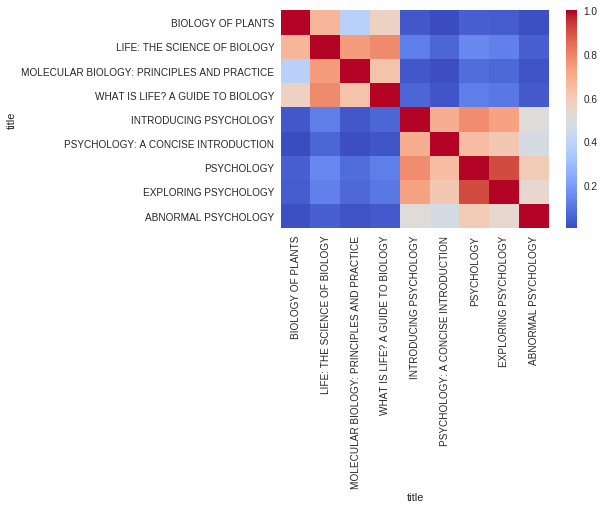

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ax = sns.heatmap(corr_matrix, cmap='coolwarm')